In [1]:
import torch
import monai
import timm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, CenterCrop
from torch.utils.data import DataLoader

N_CLASSES = 4
VAL_ROOT = 'd:/Data/PTX/validation'
BATCH_SIZE = 64
RESIZED_SIZE = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms = Compose([
    ToTensor(),
    Resize(size=(RESIZED_SIZE, RESIZED_SIZE), antialias=True),
    CenterCrop(size=(RESIZED_SIZE, RESIZED_SIZE))
])

val_dataset = ImageFolder(root=VAL_ROOT, transform=transforms)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=len(val_dataset),
                            shuffle=False)

c:\Users\szabo\anaconda3\envs\lung_us\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test_epoch2(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    model.eval()
    model.to(device)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.softmax(1).argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

def validate(model, val_dataloader, device='cpu'):
    loss_fn = torch.nn.CrossEntropyLoss()
    loss, acc = test_epoch2(model, val_dataloader, loss_fn, device)
    print(f'loss: {loss:.4f}, acc: {acc:.4f}')
    return loss, acc

def predict(model, dataset, device):
    model.eval()
    model.to(device)
    preds = []
    with torch.no_grad():
        for X, y in dataset:
            X = X.unsqueeze(dim=0).to(device)
            individual_preds = model(X)
            probabilities = np.stack([torch.softmax(pred, dim=1).cpu().numpy() for pred in individual_preds], axis=0)
            preds.append(probabilities)
    ret = np.stack(preds, axis=0)
    return ret.squeeze()

In [3]:
from monai.visualize.class_activation_maps import GradCAM, GradCAMpp

class EnsembleClassifier(torch.nn.Module):
    def __init__(self, models, target_layers):
        super().__init__()
        self.models = models
        self.gradcams = [GradCAMpp(model, target_layer) for model, target_layer in zip(models, model_target_layers)]
    
    def forward(self, x):
        return [model(x) for model in self.models]

    def get_gradcams(self, x):
        return [1-gradcam(x) for gradcam in self.gradcams]


In [4]:
def gradcam_overlay(image, gradcam, colormap='jet', opacity=0.2):
    plt.imshow(image, cmap='gray')
    plt.imshow(gradcam, cmap=colormap, alpha=opacity)

In [5]:
model_names = ['resnet50', 'xception', 'inception_v3', 'inception_resnet_v2', 'vgg16']
model_weights = ['ResNet_best.pt', 'Xception_best.pt', 'InceptionV3_best.pt', 'InceptionResnetV2_best.pt', 'VGG_best.pt']
weights_subfolder = '4class'
model_target_layers = ['layer4.2.act3', 'act4', 'Mixed_7c.branch_pool.bn.act', 'conv2d_7b.bn.act', 'features.29']

models = [timm.create_model(model_name,
                            pretrained=True,
                            num_classes=N_CLASSES,
                            drop_rate=0.5).to(DEVICE) for model_name in model_names]

for i, model in enumerate(models):
    model.load_state_dict(torch.load(f'weights/{weights_subfolder}/{model_weights[i]}'))
    print(f'Loaded {model_names[i]} successfully')

ensemble_model = EnsembleClassifier(models, model_target_layers)
ensemble_model.to(DEVICE)

c:\Users\szabo\anaconda3\envs\lung_us\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Loaded resnet50 successfully
Loaded xception successfully
Loaded inception_v3 successfully
Loaded inception_resnet_v2 successfully
Loaded vgg16 successfully


EnsembleClassifier()

In [6]:
for model in ensemble_model.models:
    validate(model, val_dataloader, DEVICE)

loss: 0.0066, acc: 0.8736
loss: 0.0040, acc: 0.9425
loss: 0.0026, acc: 0.9138
loss: 0.0035, acc: 0.8851
loss: 0.0011, acc: 0.9310


In [7]:
preds = predict(ensemble_model, val_dataset, DEVICE)
preds = preds.transpose(1,0,2)

In [8]:
true_labels = torch.IntTensor(val_dataset.targets)
individual_model_preds = [torch.from_numpy(pred).argmax(1) for pred in preds]
ensemble_model_preds = preds.mean(axis=0).argmax(axis=1)


In [9]:
true_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3], dtype=torch.int32)

In [10]:
from general import get_metrics_from_confusion_matrix

all_preds = [ensemble_model_preds] + individual_model_preds


accuracy, sensitivity, specificity = get_metrics_from_confusion_matrix(true_labels, torch.from_numpy(ensemble_model_preds), N_CLASSES)
sensitivity, specificity, accuracy


(array([1.        , 0.74285714, 0.95      , 1.        ]),
 array([0.98648649, 1.        , 0.67857143, 1.        ]),
 0.9425287356321839)

In [12]:
accuracy

0.9425287356321839

: 

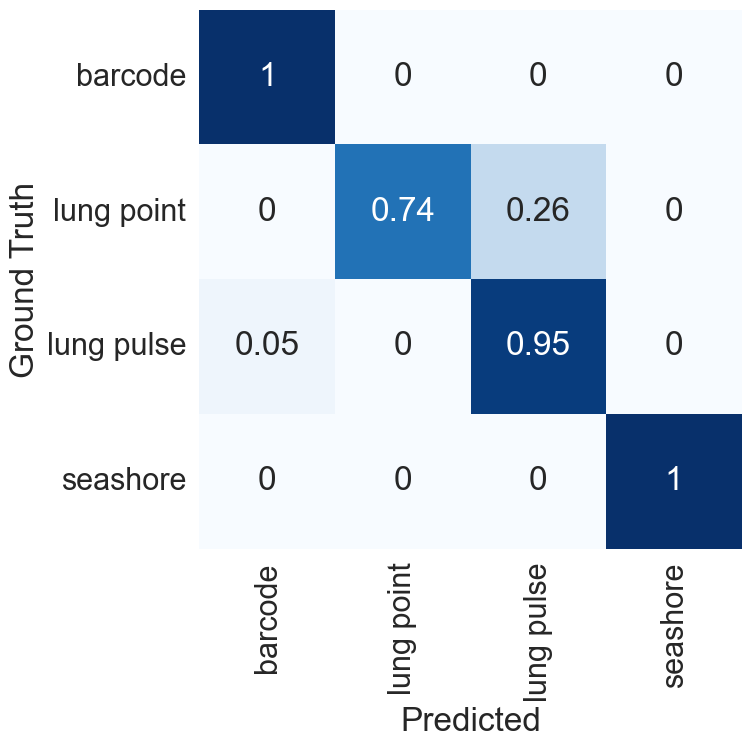

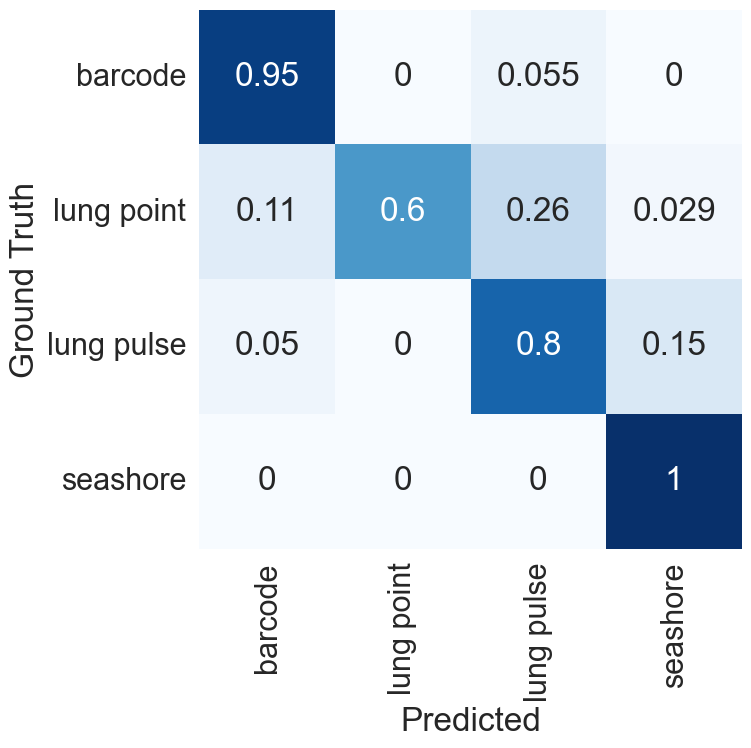

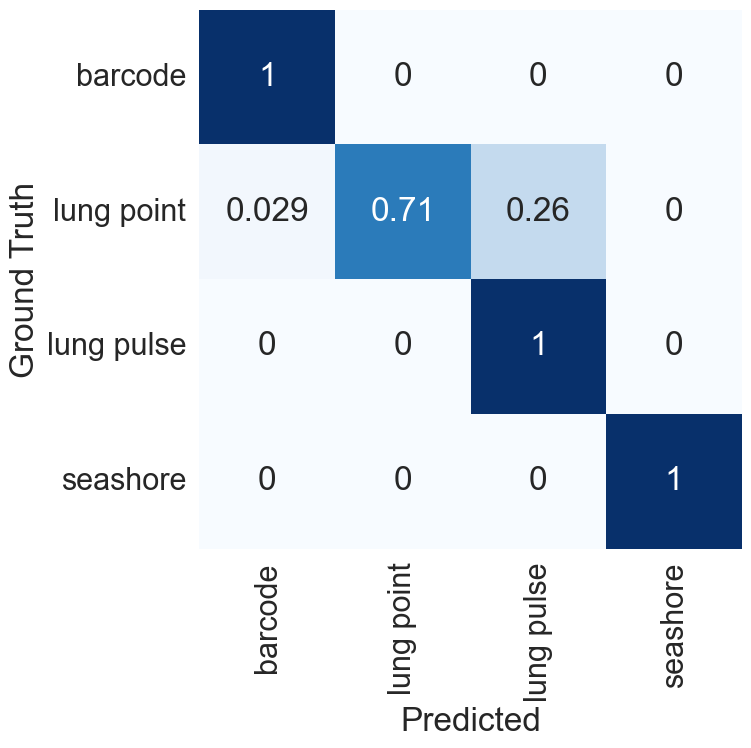

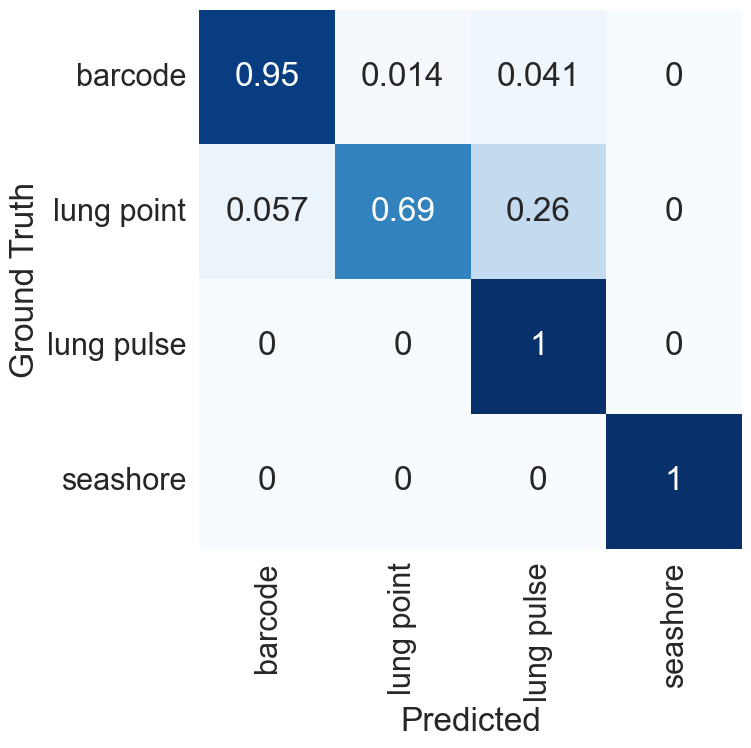

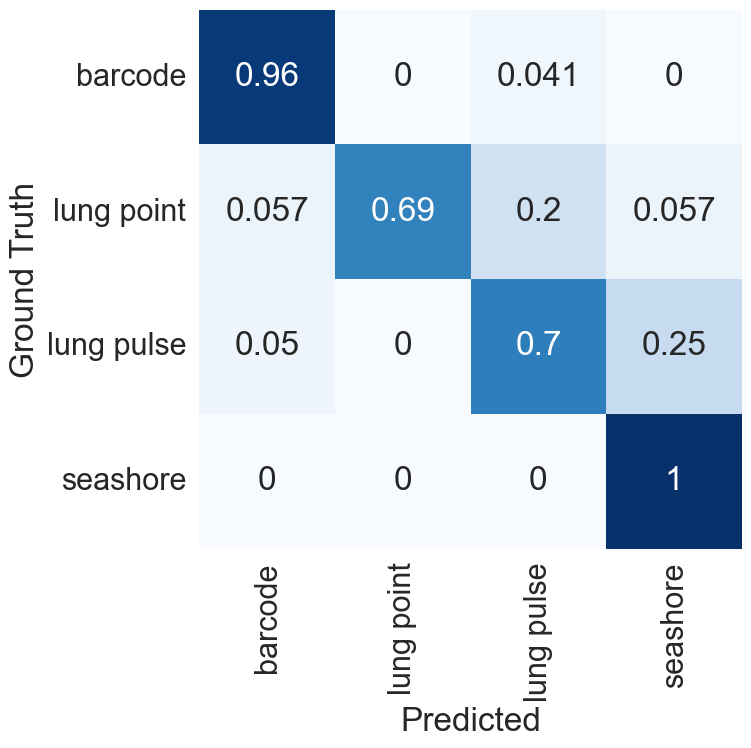

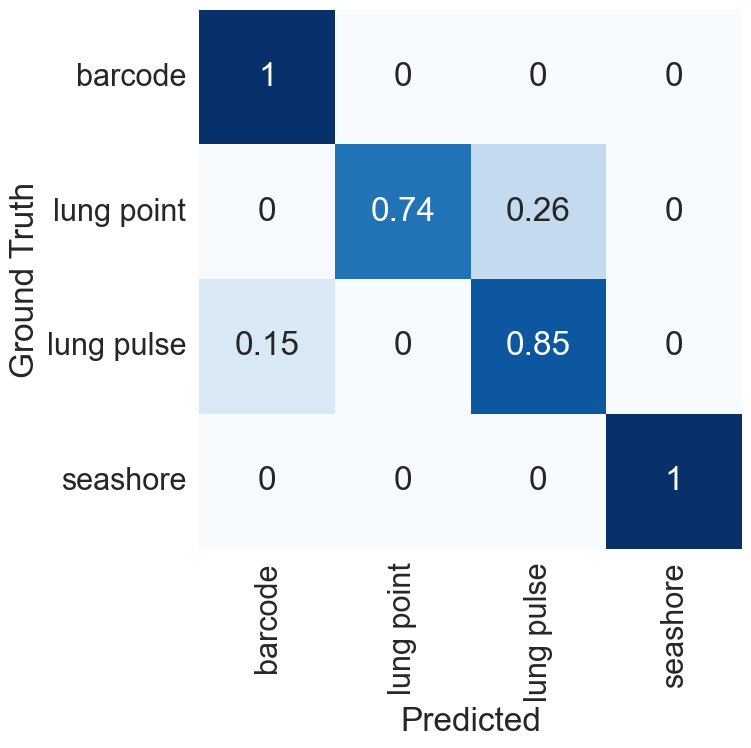

In [11]:
from general import *

display_confusion_matrix(true_labels, ensemble_model_preds, val_dataset.class_to_idx.keys())

for i, pred in enumerate(individual_model_preds):
    display_confusion_matrix(true_labels, pred, val_dataset.class_to_idx.keys())

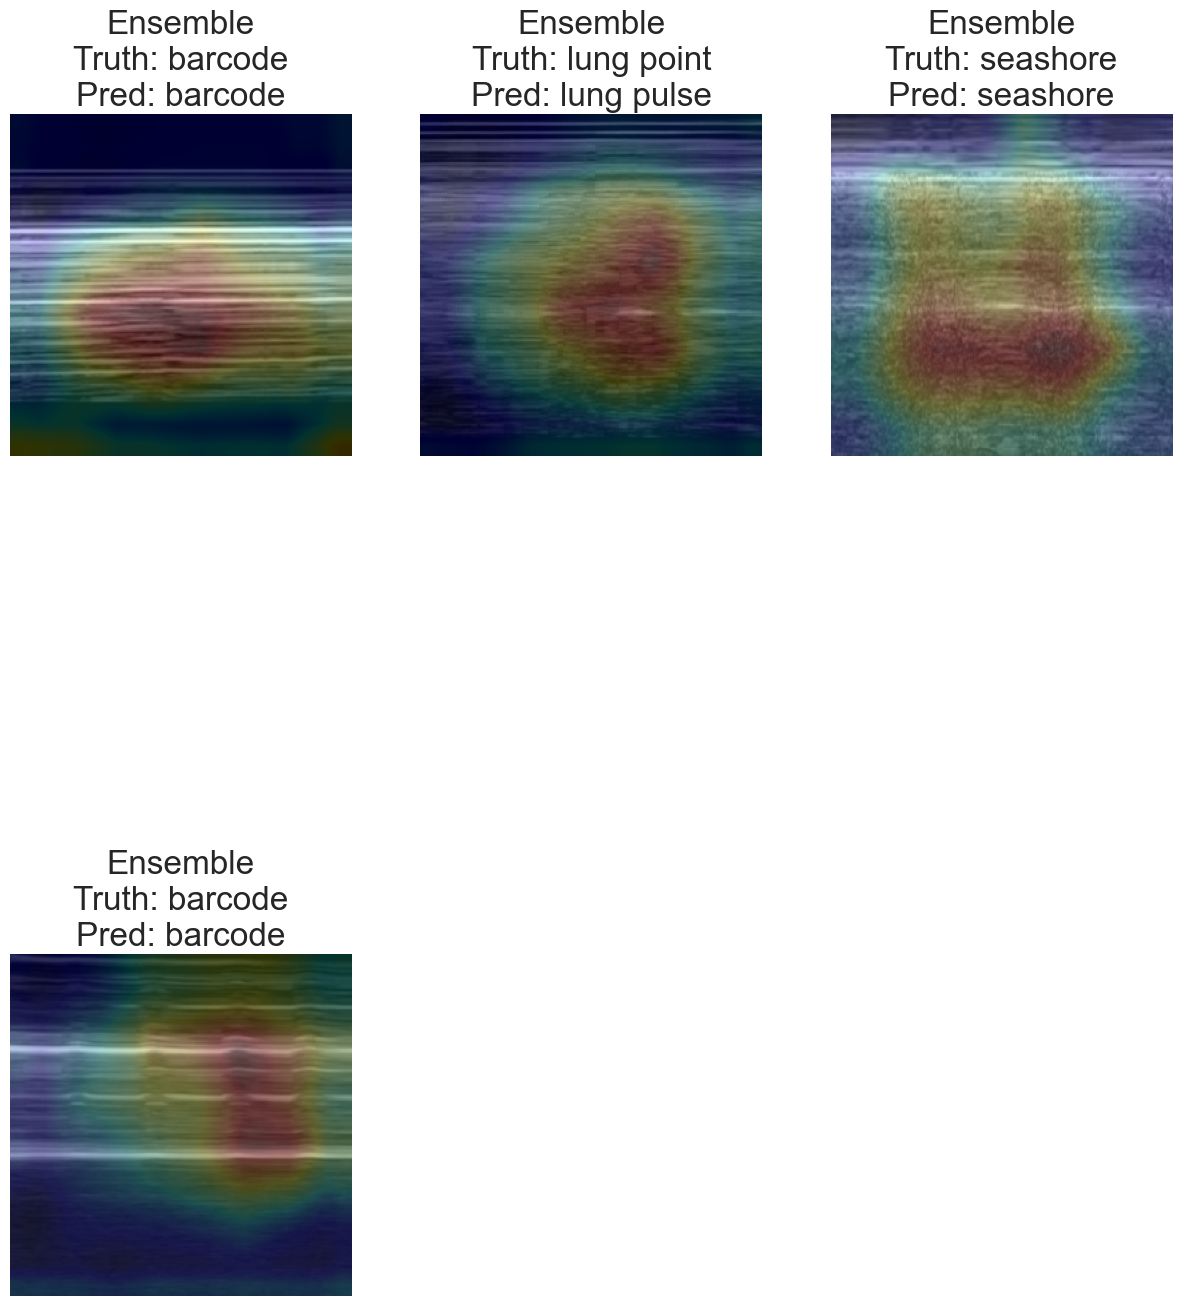

In [18]:
n = 3
plt.figure(figsize=(15, 20))

class1_id = 89
class0_id = 17
class2_id = 156
class3_id = 60
class_example_ids = [class0_id, class1_id, class2_id, class3_id]

class_names = {v: k for k, v in val_dataset.class_to_idx.items()}

for i, class_example_id in enumerate(class_example_ids):
    plt.subplot(n // 3 + 1, 3, i+1)
    #image_number = np.random.randint(len(val_dataset))
    test_image = val_dataset[class_example_id][0].unsqueeze(0)
    test_label = val_dataset[class_example_id][1]

    ensemble_model.eval()
    preds = ensemble_model(test_image.to(DEVICE))
    gradcams = ensemble_model.get_gradcams(test_image.to(DEVICE))

    ensemble_pred = np.mean(np.stack([pred.softmax(1).detach().cpu().numpy() for pred in preds]), axis=0).argmax(1).item()
    ensemble_gradcam = torch.nanmean(torch.stack(gradcams), dim=0)

    gradcam_overlay(test_image.squeeze(0).permute(1, 2, 0), ensemble_gradcam[0].squeeze(0).cpu().numpy(), opacity=0.20)
    plt.title(f'Ensemble\nTruth: {class_names[test_label]}\nPred: {class_names[ensemble_pred]}')
    plt.axis('off')

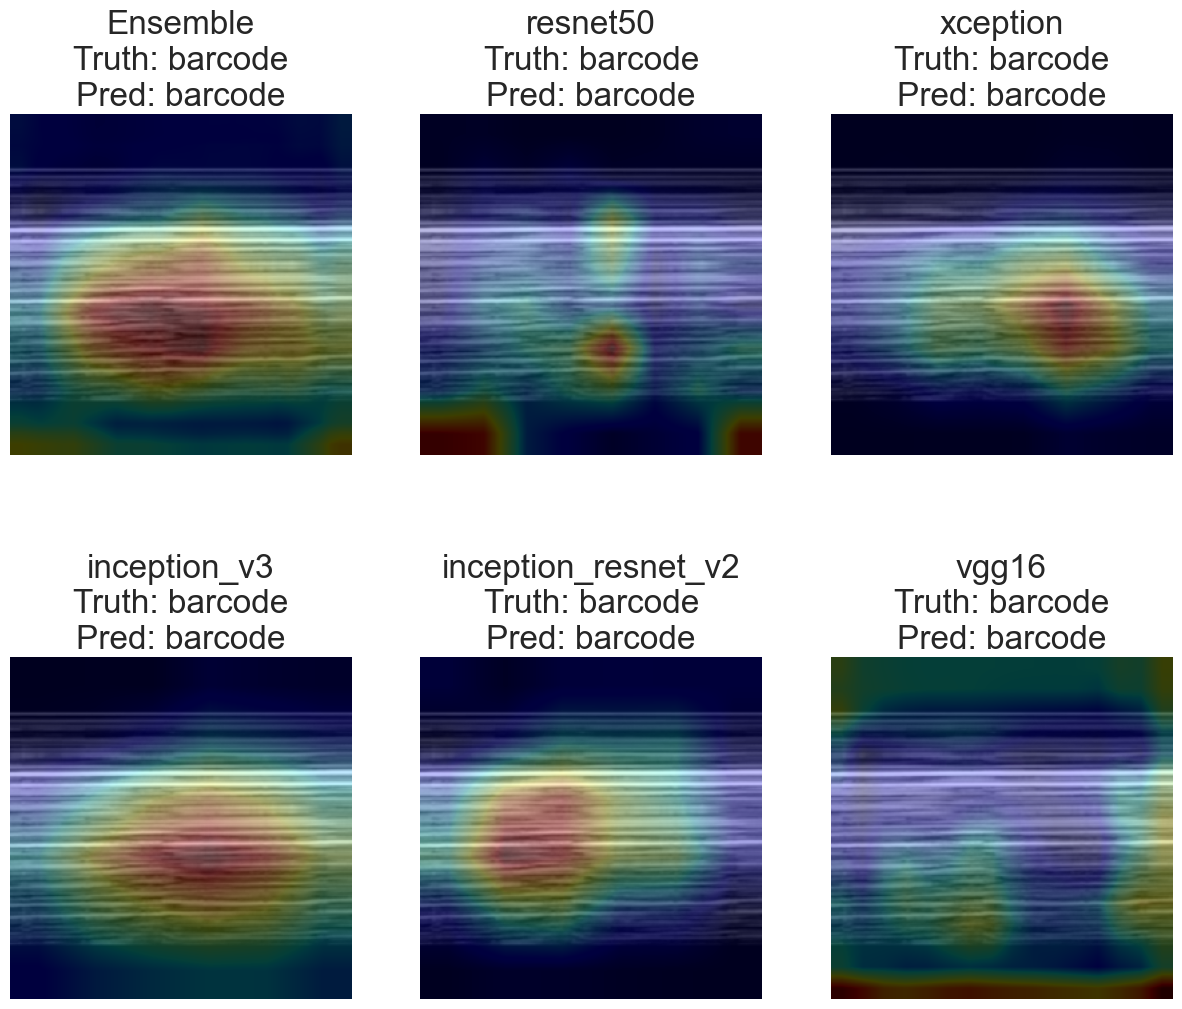

In [19]:
n = 5
plt.figure(figsize=(15, 20))
class1_id = 89
class0_id = 17
class2_id = 156
image_per_row = 3
class_names = {v: k for k, v in val_dataset.class_to_idx.items()}

#class_example_ids = [class0_id, class1_id, class2_id]
class_example_ids = [np.random.randint(len(val_dataset))]

for i, class_example_id in enumerate(class_example_ids):
    rowcount = (len(class_example_ids) // image_per_row + 1)*image_per_row
    test_image = val_dataset[class_example_id][0].unsqueeze(0)
    test_label = val_dataset[class_example_id][1]

    ensemble_model.eval()
    preds = ensemble_model(test_image.to(DEVICE))
    gradcams = ensemble_model.get_gradcams(test_image.to(DEVICE))

    ensemble_pred = np.mean(np.stack([pred.softmax(1).detach().cpu().numpy() for pred in preds]), axis=0).argmax(1).item()
    ensemble_gradcam = torch.nanmean(torch.stack(gradcams), dim=0)

    # Ensemble GradCAM
    plt.subplot(rowcount, image_per_row, i*image_per_row+1)
    gradcam_overlay(test_image.squeeze(0).permute(1, 2, 0), ensemble_gradcam[0].squeeze(0).cpu().numpy(), opacity=0.25)
    plt.title(f'Ensemble\nTruth: {class_names[test_label]}\nPred: {class_names[ensemble_pred]}')
    plt.axis('off')

    # Individual GradCAMs
    for j in range(len(model_names)):
        plt.subplot(rowcount, image_per_row, i*image_per_row + j+2)
        gradcam_overlay(test_image.squeeze(0).permute(1, 2, 0), gradcams[j][0].squeeze(0).cpu().numpy(), opacity=0.25)
        plt.title(f'{model_names[j]}\nTruth: {class_names[test_label]}\nPred: {class_names[preds[j].softmax(1).argmax(1).item()]}')
        plt.axis('off')

In [49]:
val_dataset.class_to_idx

{'barcode': 0, 'lung pulse': 1, 'seashore': 2}

In [51]:
class_names = {v: k for k, v in val_dataset.class_to_idx.items()}
class_names[0]

'barcode'